In [177]:
# magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
import dask.dataframe as dd
from tape import Ensemble, ColumnMapper

In [39]:
%%time
# load lite version of Gaia DR3 for quick cone searches
gaia_lite = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic", columns=['ra',
                                                                                         'dec', 
                                                                                         "parallax", 
                                                                                         "phot_g_mean_mag"])

CPU times: user 4.51 s, sys: 583 ms, total: 5.09 s
Wall time: 4.25 s


In [2]:
%%time
#Load ZTF, Gaia, and ZTF sources hipscats # note data3/ for epyc
gaia = lsdb.read_hipscat("/epyc/data3/hipscat/test_catalogs/gaia_symbolic")

# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

# Load ZTF DR14 sources
ztf_sources = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_source")

CPU times: user 1min 9s, sys: 18 s, total: 1min 27s
Wall time: 1min 27s


In [7]:
%%time
# crossmatch ZTF + Gaia - for the sake of speed - let's do a simple cone search.
_all_sky_object = gaia.cone_search(ra=35, dec=55, radius=10).crossmatch(ztf).query(
    "nobs_g_ztf_dr14 > 50 and nobs_r_ztf_dr14 > 50 and \
    parallax_gaia > 0 and parallax_over_error_gaia > 5 and \
    teff_gspphot_gaia > 5380 and teff_gspphot_gaia < 7220 and logg_gspphot_gaia > 4.5 \
    and logg_gspphot_gaia < 4.72 and classprob_dsc_combmod_star_gaia > 0.5").compute()

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data_frame["_CONE_SEP"] = df_separations
/astro/users/atzanida/lsdbgithub/lsdb/src/lsdb/core/cone_search.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  

CPU times: user 4min 58s, sys: 12min 58s, total: 17min 56s
Wall time: 1min 57s


In [9]:
%%time 
# Convert crossmatch _sample to lsdb Catalog object
_sample_hips = lsdb.from_dataframe(
    _all_sky_object, 
    lowest_order=5, 
    highest_order=8, 
    ra_column="ra_gaia", 
    dec_column="dec_gaia", 
    threshold=1_000_000
)

CPU times: user 2.38 s, sys: 240 ms, total: 2.62 s
Wall time: 2.63 s


In [11]:
%%time
# merge sources to sample hips object
_sources = _sample_hips.join(
    ztf_sources, left_on="ps1_objid_ztf_dr14", right_on="ps1_objid")

CPU times: user 11.1 s, sys: 990 ms, total: 12.1 s
Wall time: 11.8 s


In [10]:
# Initialize an Ensemble
ens = Ensemble(memory_limit=1e11, n_workers=12)
ens.client_info()

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33506 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33506/status,
Dashboard: http://127.0.0.1:33506/status,Workers: 12
Total threads: 96,Total memory: 1.09 TiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40038,Workers: 12
Dashboard: http://127.0.0.1:33506/status,Total threads: 96
Started: Just now,Total memory: 1.09 TiB
Comm: tcp://127.0.0.1:43151,Total threads: 8
Dashboard: http://127.0.0.1:33702/status,Memory: 93.13 GiB
Nanny: tcp://127.0.0.1:34108,


In [13]:
# ColumnMapper Establishes which table columns map to timeseries quantities
colmap = ColumnMapper(
        id_col='_hipscat_index',
        time_col='mjd',
        flux_col='mag',
        err_col='magerr',
        band_col='band',
      )

In [14]:
%%time
# We can read from parquet
ens.from_dask_dataframe(
    source_frame=_sources._ddf,
    object_frame=_sample_hips._ddf,
    column_mapper=colmap,
    sync_tables=False, # Avoid doing an initial sync
    sorted=True, # If the input data is already sorted by the chosen index
    sort=False,
)

CPU times: user 158 ms, sys: 54.8 ms, total: 212 ms
Wall time: 202 ms


/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(
/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/dataframe/core.py:5400: UserWarning: New index has same name as existing, this is a no-op.
  warnings.warn(


In [17]:
%%time
lc = ens.source.loc[814641612607979520].compute()

CPU times: user 1.64 s, sys: 684 ms, total: 2.32 s
Wall time: 6.54 s


In [152]:
lc.head(3)

,solution_id_gaia_,designation_gaia_,source_id_gaia_,random_index_gaia_,ref_epoch_gaia_,ra_gaia_,ra_error_gaia_,dec_gaia_,dec_error_gaia_,parallax_gaia_,...,catflags_ztf_source,fieldID_ztf_source,mag_ztf_source,magerr_ztf_source,mjd_ztf_source,rcID_ztf_source,band_ztf_source,Norder_ztf_source,Dir_ztf_source,Npix_ztf_source
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
814641612607979520,1636148068921376768,Gaia DR3 407320786956929152,407320786956929152,943148244,2016.0,22.694575,0.031304,52.452644,0.029738,0.62217,...,0,774,16.244547,0.012237,58450.35117,0,r,8,40000,46307
814641612607979520,1636148068921376768,Gaia DR3 407320786956929152,407320786956929152,943148244,2016.0,22.694575,0.031304,52.452644,0.029738,0.62217,...,0,775,16.226385,0.014071,58455.30089,13,r,8,40000,46307
814641612607979520,1636148068921376768,Gaia DR3 407320786956929152,407320786956929152,943148244,2016.0,22.694575,0.031304,52.452644,0.029738,0.62217,...,-32768,775,16.285412,0.014258,58450.33218,13,r,8,40000,46307


## Local Tools

In [118]:
import sys
sys.path.insert(1, '../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models

### Example Source

In [139]:
time, mag, magerr = my_tools.prepare_lc(lc['mjd_ztf_source'],
                   lc['mag_ztf_source'], 
                   lc['magerr_ztf_source'], 
                   lc['catflags_ztf_source'],
                   lc['band_ztf_source'], band_of_study='r', flag_good=0)

# running deviation wrt to biweight location and scale
dev = dip_pipeline.deviation(mag, magerr)

Text(0, 0.5, 'mag (ztf-r)')

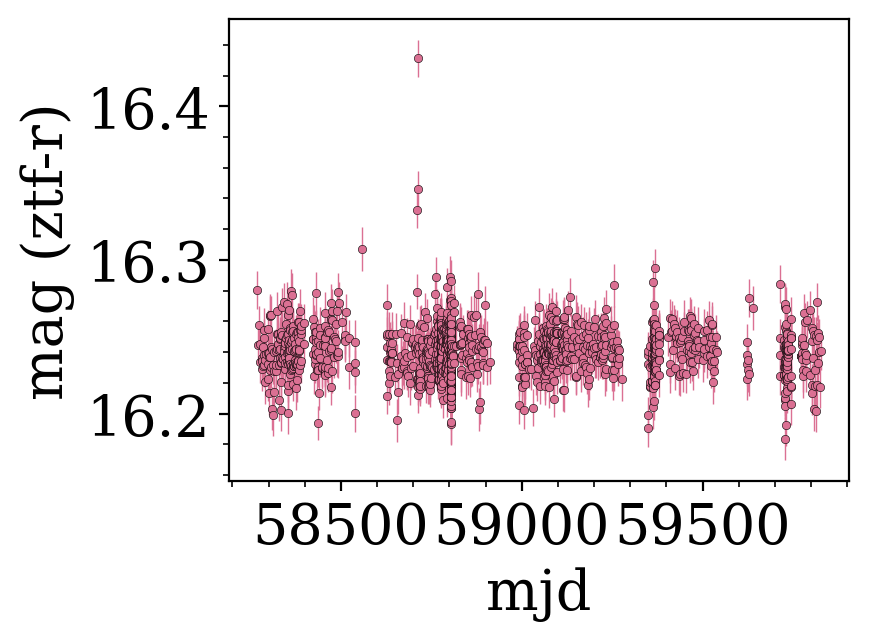

In [165]:
plt.figure(figsize=(4, 3))
plt.errorbar(time, mag, magerr, fmt='.', color='palevioletred', mec='k', mew=0.2, lw=0.5)
plt.minorticks_on()
plt.xlabel("mjd")
plt.ylabel('mag (ztf-r)')

Text(0, 0.5, 'ξ [dev]')

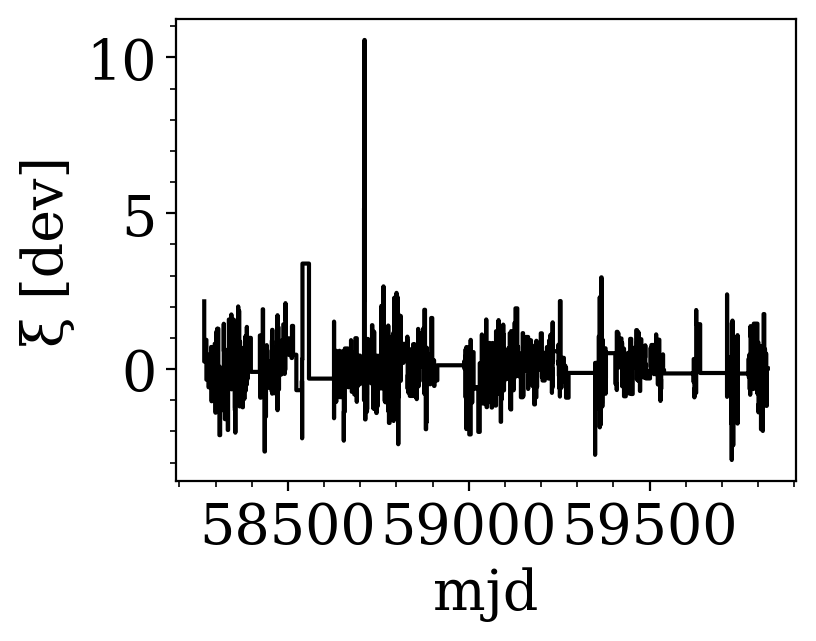

In [166]:
plt.figure(figsize=(4, 3))
plt.step(time, dev, color='k')
plt.minorticks_on()
plt.xlabel("mjd")
plt.ylabel('ξ [dev]')

In [183]:
# test my dipper detection pipeline
dip_pipeline.peak_detector(time, dev, power_thresh=3,
    peak_close_rmv=15,
    pk_2_pk_cut=30)

(1,
 {'dip_0': {'peak_loc': 58712.38555,
   'window_start': 58712.44872,
   'window_end': 58710.39241,
   'N_1sig_in_dip': 4,
   'N_in_dip': 6,
   'loc_forward_dur': 0.06317000000126427,
   'loc_backward_dur': 1.9931399999986752,
   'dip_power': 10.55637,
   'average_dt_dif': 0.40761599999968895}})

In [180]:
%%time
# estimate the gaia density field
my_tools.estimate_gaiadr3_density(22.694575, 52.452644, gaia_lite)

CPU times: user 372 ms, sys: 76.8 ms, total: 449 ms
Wall time: 723 ms


{'closest_bright_star_arcsec': 20.557534607614198,
 'closest_bright_star_mag': 14.098287,
 'closest_star_arcsec': 0.0008414113091178522,
 'closest_star_mag': 16.294292,
 'density_arcsec2': 29781.891398967557}